In [417]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [418]:
# Gauss-Seidel iterative solution of Ax=b
def gauss_seidel(A, b, x, tolerance=1e-10, max_iterations=10000):
    iter1 = 0
    for k in range(max_iterations):
        iter1 += 1   
        x_old  = x.copy()
        #Loop over rows
        for i in range(A.shape[0]):
            x[i] = (b[i] - np.dot(A[i,:i], x[:i]) - np.dot(A[i,(i+1):], x_old[(i+1):])) / A[i ,i]
        #Stop condition 
        if  max(abs((x - x_old)))/max(abs(x_old)) < tolerance:
            break
    #print("The L infinity norm in iteration", iter1,"is:", max(abs((x - x_old)))/max(abs(x_old)))       
    return x

# solve the linear system Ax=b
def solve_linear(A, b):
        #return np.linalg.solve(A, b)
        return gauss_seidel(A, b, -b)
        #return np.linalg.pinv(A).dot(b) 

### Advection-Transport

$
\frac{\displaystyle \partial u}{\displaystyle \partial t} + \mathbf{v} \cdot \nabla u = f 
$

where

$\nabla \cdot \mathbf{v} = 0$ (incompressible flow)


#### Courant–Friedrichs–Lewy number

$
CFL = \frac{\displaystyle v \Delta t}{\displaystyle \Delta x}  \hspace{0.5cm} \text{one dimentional}\\
CFL \le 1
$


In [492]:
# (solve Au=f for each time step) 

class Transport: 
    """
    Finite difference solution of the Transport/Advection equation (hyperbolic equation)

    Parameters
    ----------   
    velocity: float
        Velocity in m/s
    dx: float
        Block size in meters
    N: int
        Number of blocks
    initial_condition: list (or numpy array) of floats
        Initial condition (one value per block -> size N)
    boundary_type: list (or numpy array) of str | default ['Dirichlet','Dirichlet']
        Left and right boundary condition type (options: 'Dirichlet', 'Neumann' or 'periodic'), e.g. ['Dirichlet','Neumann'] or ['periodic','periodic']  
    boundary_values: list (or numpy array) of floats | default [0., 0.]    
        Left and right boundary condition values, e.g. [10., -1.]
    time_integration: str | default 'implicit'
        Time integration (options: explict, implicit or Crank-Nicolson), e.g. 'implicit'
    space_discretization: str | default 'upwind'
        Space discretization (options: central or upwind), e.g. 'upwind'
    
    Methods
    -------
    forward(dt, source_term=None)
        Solve the transport equation for one time step of size dt considering the source term

    """  
    def __init__(self, velocity, dx, N, initial_condition, boundary_type = ['Dirichlet','Dirichlet'], boundary_values=[0, 0], time_integration='implicit', space_discretization='upwind'):   
        self.velocity = velocity
        self.dx = dx 
        self.N = N  
        self.u_previous = np.array(initial_condition) # For the first time step
        self.boundary_type = boundary_type
        self.boundary_values = boundary_values
        self.time_integration = time_integration 
        self.space_discretization = space_discretization
        self.timestep_count = 0
        if space_discretization == 'upwind':
            self.w = 1. if velocity>0 else 0.
        if time_integration == 'implicit' or time_integration == 'Crank-Nicolson':
            self.A = np.empty((N,N))
            self.f = np.empty(N)
    
    # Solve the heat equation explicitly  
    def solve_explicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # initialize u and add source term
        u = self.u_previous + dt*source_term
        
        # Calculate advection term for elements not in the boundary
        if self.space_discretization == 'upwind': 
            for i in range(1,self.N-1): 
                u[i] += -cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)
        elif self.space_discretization == 'central': 
            print('***WARNING This space discretization explicit in time is UNSTABLE!')
            for i in range(1,self.N-1):     
                u[i] += -(cfl/2)*(self.u_previous[i+1]-self.u_previous[i-1]) 
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')
              
        # Calculate advection term for elements in the boundaries 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            if self.space_discretization == 'upwind': 
                u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)
            elif self.space_discretization == 'central': 
                u[0] += -(cfl/2)*(self.u_previous[1]-self.boundary_values[0])  
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                
        elif self.boundary_type[0] == 'Neumann':
            if self.space_discretization == 'upwind':
                u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
            elif self.space_discretization == 'central': 
                u[0] += -(cfl/2)*(self.u_previous[1]-self.u_previous[0]+self.dx*self.boundary_values[0]) 
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')    
        elif self.boundary_type[0] == 'periodic':
            if self.space_discretization == 'upwind': 
                u[0] += -cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)
            elif self.space_discretization == 'central': 
                u[0] += -(cfl/2)*(self.u_previous[1]-self.u_previous[-1])  
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                 
        else:
            print('Left boundary: no condition satisfaed!')    
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            if self.space_discretization == 'upwind':
                u[-1] += -cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)    
            elif self.space_discretization == 'central':
                u[-1] += -(cfl/2)*(self.boundary_values[-1]-self.u_previous[-2])
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                   
        elif self.boundary_type[1] == 'Neumann':
            if self.space_discretization == 'upwind':
                u[-1] += -cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)  
            elif self.space_discretization == 'central':
                u[-1] += -(cfl/2)*(self.u_previous[-1]+self.dx*self.boundary_values[-1]-self.u_previous[-2])
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')    
        elif self.boundary_type[1] == 'periodic':
            if self.space_discretization == 'upwind':
                u[-1] += -cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)    
            elif self.space_discretization == 'central':
                u[-1] += -(cfl/2)*(self.u_previous[0]-self.u_previous[-2])
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                 
        else:
            print('Left boundary: no condition satisfaed!')                            
                
        return u

    # Solve the heat equation fully implicit  
    def solve_implicit(self, dt, source_term):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx
        
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        if self.space_discretization == 'upwind':
            self.A[:] = np.diag([1-cfl*(1-self.w)+cfl*self.w]*self.N,  0)  # Main diagonal
            self.A += np.diag([cfl*(1-self.w)]*(self.N-1), 1)              # Upper diagonal
            self.A += np.diag([-cfl*self.w]*(self.N-1),-1)                 # Lower diagonal   
        elif self.space_discretization == 'central':     
            print('***WARNING This space discretization implicit in time generates oscilations!') 
            self.A[:] = np.diag([1]*self.N,  0)         # Main diagonal
            self.A += np.diag([cfl/2]*(self.N-1), 1)    # Upper diagonal
            self.A += np.diag([-cfl/2]*(self.N-1),-1)   # Lower diagonal   
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')              
        #
        ## Source term f
        self.f[:] = self.u_previous + dt*source_term            
        
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            if self.space_discretization == 'upwind':
                self.f[0] += self.boundary_values[0]*cfl*self.w  
            elif self.space_discretization == 'central': 
                self.f[0] += self.boundary_values[0]*cfl/2 
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                 
        elif self.boundary_type[0] == 'Neumann':
            if self.space_discretization == 'upwind':
                self.f[0]  += -self.boundary_values[0]*cfl*self.dx*self.w   
                self.A[0,0] += -cfl*self.w
            elif self.space_discretization == 'central':   
                self.f[0]  += -self.boundary_values[0]*cfl*self.dx/2   
                self.A[0,0] += -cfl/2                
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')      
        elif self.boundary_type[0] == 'periodic':
            if self.space_discretization == 'upwind':
                self.A[0,-1] += -cfl*self.w  
            elif self.space_discretization == 'central': 
                self.A[0,-1] += -cfl/2 
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')             
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            if self.space_discretization == 'upwind':
                self.f[-1] += -self.boundary_values[-1]*cfl*(1-self.w)
            elif self.space_discretization == 'central':  
                self.f[-1] += -self.boundary_values[-1]*cfl/2                
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                 
        elif self.boundary_type[1] == 'Neumann':
            if self.space_discretization == 'upwind':
                self.f[-1] += -self.boundary_values[-1]*cfl*self.dx*(1-self.w)  
                self.A[-1,-1] += cfl*(1-self.w)
            elif self.space_discretization == 'central':    
                self.f[-1] += -self.boundary_values[-1]*cfl*self.dx/2  
                self.A[-1,-1] += cfl/2                
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')      
        elif self.boundary_type[1] == 'periodic':
            if self.space_discretization == 'upwind':
                self.A[-1,0] += cfl*(1-self.w)
            elif self.space_discretization == 'central':  
                self.A[-1,0] += cfl/2                
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                  
        else:
            print('Right boundary: no condition satisfaed!')         
         
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u
    
    # Solve the heat equation using Crank-Nicolson (theta = 0 -> explicit, 1-> implicit)
    def solve_CrankNicolson(self, dt, source_term, theta=0.5):
        
        # Define Courant–Friedrichs–Lewy number
        cfl = self.velocity*dt/self.dx   
                        
        # (Au=f) Calculate matrix A and f 
        #
        ## matrix A
        if self.space_discretization == 'upwind':
            self.A[:] = np.diag([1-theta*cfl*(1-self.w)+theta*cfl*self.w]*self.N,  0)  # Main diagonal
            self.A += np.diag([theta*cfl*(1-self.w)]*(self.N-1), 1)                    # Upper diagonal
            self.A += np.diag([-theta*cfl*self.w]*(self.N-1),-1)                       # Lower diagonal 
        elif self.space_discretization == 'central': 
            print('***WARNING This space discretization implicit in time generates oscilations!')   
            self.A[:] = np.diag([1]*self.N,  0)               # Main diagonal
            self.A += np.diag([theta*cfl/2]*(self.N-1), 1)    # Upper diagonal
            self.A += np.diag([-theta*cfl/2]*(self.N-1),-1)   # Lower diagonal 
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')               
        #
        ## Source term f
        self.f[:] = self.u_previous + dt*source_term
        if self.space_discretization == 'upwind':
            for i in range(1,self.N-1):
                self.f[i] += -(1-theta)*cfl*((self.u_previous[i+1]-self.u_previous[i])*(1-self.w)+(self.u_previous[i]-self.u_previous[i-1])*self.w)
        elif self.space_discretization == 'central':
            for i in range(1,self.N-1):
                self.f[i] += -(1-theta)*(cfl/2)*(self.u_previous[i+1]-self.u_previous[i-1])
        else:
            print(f'Space discretization {self.space_discretization} NOT available!')          
        
        # Calculate boundary conditions 
        #
        ## Left boundary
        if self.boundary_type[0] == 'Dirichlet':
            if self.space_discretization == 'upwind':
                self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.boundary_values[0])*self.w)
                self.f[0] += theta*self.boundary_values[0]*cfl*self.w 
            elif self.space_discretization == 'central': 
                self.f[0] += -(1-theta)*(cfl/2)*(self.u_previous[1]-self.boundary_values[0])
                self.f[0] += theta*self.boundary_values[0]*cfl/2 
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                 
        elif self.boundary_type[0] == 'Neumann':
            if self.space_discretization == 'upwind':
                self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.dx*self.boundary_values[0])*self.w)
                self.f[0] += -theta*self.boundary_values[0]*cfl*self.dx*self.w 
                self.A[0,0] += -theta*cfl*self.w
            elif self.space_discretization == 'central':     
                self.f[0] += -(1-theta)*(cfl/2)*(self.u_previous[1]-self.u_previous[0]+self.dx*self.boundary_values[0])
                self.f[0] += -theta*self.boundary_values[0]*cfl*self.dx/2
                self.A[0,0] += -theta*cfl/2
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')   
        elif self.boundary_type[0] == 'periodic':
            if self.space_discretization == 'upwind':
                self.f[0] += -(1-theta)*cfl*((self.u_previous[1]-self.u_previous[0])*(1-self.w)+(self.u_previous[0]-self.u_previous[-1])*self.w)                
                self.A[0,-1] += -theta*cfl*self.w  
            elif self.space_discretization == 'central': 
                self.f[0] += -(1-theta)*(cfl/2)*(self.u_previous[1]-self.u_previous[-1])
                self.A[0,-1] += -theta*cfl/2 
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                    
        else:
            print('Left boundary: no condition satisfaed!')
        #
        ## Right boundary
        if self.boundary_type[1] == 'Dirichlet':
            if self.space_discretization == 'upwind':
                self.f[-1] += -(1-theta)*cfl*((self.boundary_values[-1]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
                self.f[-1] += -theta*self.boundary_values[-1]*cfl*(1-self.w)
            elif self.space_discretization == 'central': 
                self.f[-1] += -(1-theta)*(cfl/2)*(self.boundary_values[-1]-self.u_previous[-2])
                self.f[-1] += -theta*self.boundary_values[-1]*cfl/2
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')          
        elif self.boundary_type[1] == 'Neumann':
            if self.space_discretization == 'upwind':
                self.f[-1] += -(1-theta)*cfl*((self.dx*self.boundary_values[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)
                self.f[-1] += -theta*self.boundary_values[-1]*cfl*self.dx*(1-self.w) 
                self.A[-1,-1] += theta*cfl*(1-self.w)
            elif self.space_discretization == 'central': 
                self.f[-1] += -(1-theta)*(cfl/2)*(self.u_previous[-1]+self.dx*self.boundary_values[-1]-self.u_previous[-2])
                self.f[-1] += -theta*self.boundary_values[-1]*cfl*self.dx/2  
                self.A[-1,-1] += theta*cfl/2
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')  
        elif self.boundary_type[1] == 'periodic':
            if self.space_discretization == 'upwind':
                self.f[-1] += -(1-theta)*cfl*((self.u_previous[0]-self.u_previous[-1])*(1-self.w)+(self.u_previous[-1]-self.u_previous[-2])*self.w)                
                self.A[-1,0] += theta*cfl*(1-self.w)
            elif self.space_discretization == 'central': 
                self.f[-1] += -(1-theta)*(cfl/2)*(self.u_previous[0]-self.u_previous[-2])                
                self.A[-1,0] += theta*cfl/2                
            else:
                print(f'Space discretization {self.space_discretization} NOT available!')                                
        else:
            print('Right boundary: no condition satisfaed!')
          
        # Calculate u from Au=f
        u = solve_linear(self.A, self.f)
        
        return u 
    
            
    def forward(self, dt, source_term=None):
        """
        Solve the transport equation for one time step of size dt considering the source term
        
        
        Parameters
        ----------
        dt: float
            Time step size in seconds
        source_term: list (or numpy array) of floats | default None
            Source term (one value per block -> size N)
        
        Returns
        ----------
        u: numpy array of floats
            resulted field after time step dt (one value per block -> size N)

        """          
        source_term = np.array(self.N*[0]) if source_term == None else np.array(source_term)
        
        if self.time_integration == 'implicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_implicit(dt, source_term)
            self.u_previous[:] = u
            
        elif self.time_integration == 'Crank-Nicolson':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}, total time = {self.timestep_count*dt}s')
          
            u = self.solve_CrankNicolson(dt, source_term, theta=0.5)
            self.u_previous[:] = u            
        
        elif self.time_integration == 'explicit':
            self.timestep_count += 1
            print(f'Time step {self.timestep_count} => dt = {dt}s, cfl = {self.velocity*dt/self.dx:.2f}{"(***WARNING cfl>1)" if self.velocity*dt/self.dx > 1.0 else ""}, total time = {self.timestep_count*dt}s')
           
            u = self.solve_explicit(dt, source_term)
            self.u_previous[:] = u
            
        else:
            print(f'Time integration {self.time_integration} NOT available!')
            return None
        
        return u

### Solve implicit

In [535]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=11, #110 
            initial_condition = 4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='implicit',
            space_discretization='upwind')

In [536]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, total time = 2.5s
0.003742218017578125


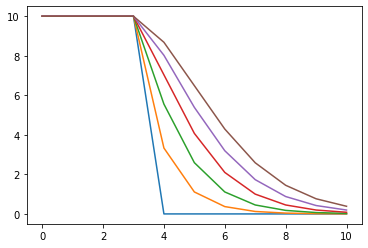

In [537]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_imp = u

A = 
 [[ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5  1.5  0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  1.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  1.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -0.5  1.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  1.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  1.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  1.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.5  1.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  1.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  1.5]]

u = 
 [10.         10.         10.         10.          8.68312757  6.48834019
  4.29355281  2.58649596  1.44845806  0.76563532  0.38628935]

f = 
 [10.         10.         10.         10.          8.02469136  5.3909465
  3.19615912  1.73296754  0.87943911  0.42422395  0.19661637]

Determinant = 57.66503906250008
Error =  1.7763568394002505e-15


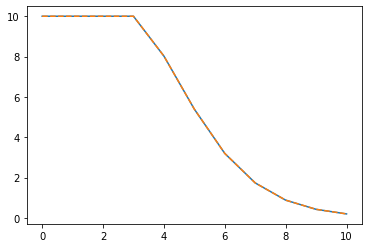

In [538]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[10.         10.         10.         10.          8.68312757  6.48834019
  4.29355281  2.58649596  1.44845806  0.76563532  0.38628935]


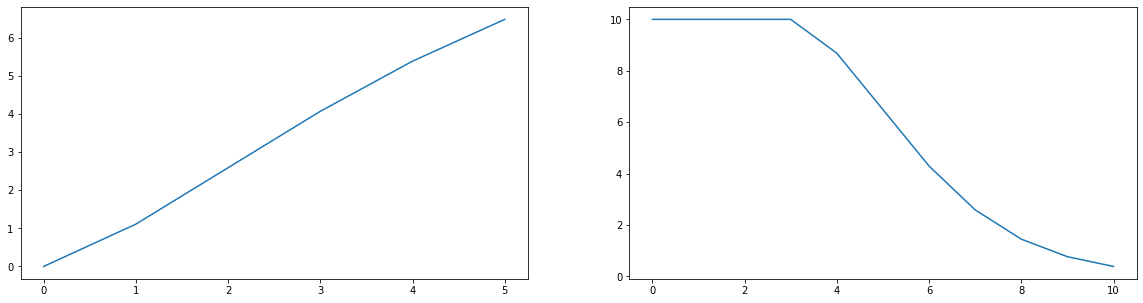

In [539]:
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_imp)[:,5])
axes[1].plot(u_imp[-1])

### Solve explicit

In [542]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=11, #110
            initial_condition = 4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)),
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='explicit',
            space_discretization='upwind')

In [543]:
print(f'Greatest time step explicit = {transport.dx/transport.velocity:.2f}s')

Greatest time step explicit = 1.00s


In [544]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, total time = 2.5s
0.0007841587066650391


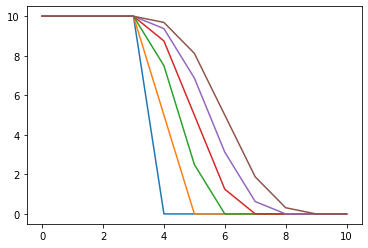

In [545]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=4*[0.]+3*[0.]+4*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_exp = u

[10.     10.     10.     10.      9.6875  8.125   5.      1.875   0.3125
  0.      0.    ]
[10.         10.         10.         10.          8.68312757  6.48834019
  4.29355281  2.58649596  1.44845806  0.76563532  0.38628935]


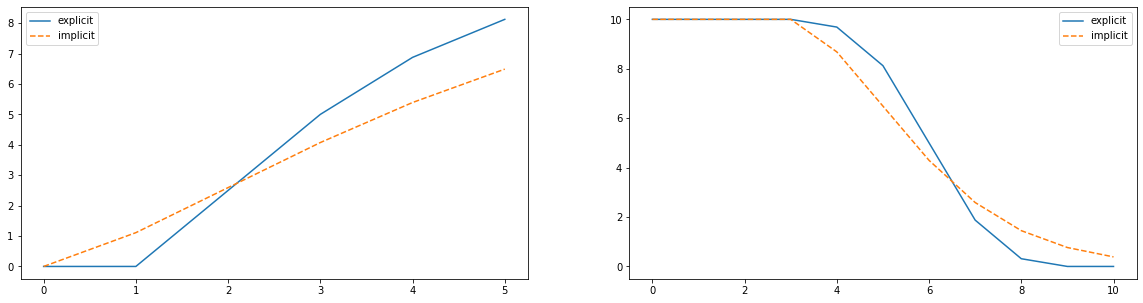

In [546]:
print(u_exp[-1])
print(u_imp[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].legend(['explicit','implicit'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].legend(['explicit','implicit'])

### Solve Crank-Nicolson

In [553]:
transport = Transport(velocity = 0.1, 
            dx=0.1,
            N=11, #110 
            initial_condition = 4*[10.]+3*[0.]+4*[0.], #np.sin(np.linspace(0,2*np.pi,110,endpoint=False)), 
            #boundary_type = ['Dirichlet','Neumann'], 
            #boundary_type = ['Dirichlet','Dirichlet'], 
            boundary_type = ['Neumann','Neumann'], 
            #boundary_type = ['periodic','periodic'], 
            boundary_values = [0, 0],
            time_integration='Crank-Nicolson',
            space_discretization='upwind')

In [554]:
# Initialize u
u=[]
u.append(transport.u_previous.copy())  # Initial condition

Time step 1 => dt = 0.5s, cfl = 0.50, total time = 0.5s
Time step 2 => dt = 0.5s, cfl = 0.50, total time = 1.0s
Time step 3 => dt = 0.5s, cfl = 0.50, total time = 1.5s
Time step 4 => dt = 0.5s, cfl = 0.50, total time = 2.0s
Time step 5 => dt = 0.5s, cfl = 0.50, total time = 2.5s
0.004379749298095703


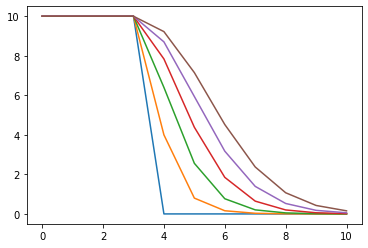

In [555]:
start = time.time()
for _ in range(5):
    u.append(transport.forward(dt=0.5, # seconds
                               #source_term=1*[0.]+9*[0.]+1*[0.]
                               )
            )
print(time.time()-start)
plt.plot(np.transpose(u));
u_cn = u

A = 
 [[ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [-0.25  1.25  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.25  1.25  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.25  1.25  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.25  1.25  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.25  1.25  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -0.25  1.25  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   -0.25  1.25  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.25  1.25  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.   -0.25  1.25  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.25  1.25]]

u = 
 [10.         10.         10.         10.          9.2224      7.1488
  4.52224     2.374912    1.0705408   0.42811597  0.1560023 ]

f = 
 [10.         10.         10.         10.          9.028       6.6304
  3.8656      1.8380

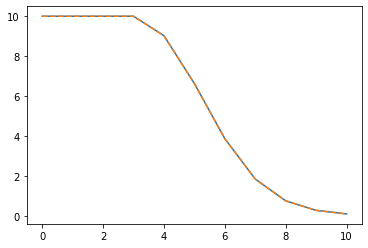

In [556]:
print('A = \n', transport.A)
print()
print('u = \n', u[-1])
print()
print('f = \n', transport.f)
print()
print('Determinant =', np.linalg.det(transport.A))
print('Error = ', np.max(abs(transport.A.dot(u[-1])-transport.f)))

plt.plot(transport.A.dot(u[-1]))
plt.plot(transport.f, '--')

[10.     10.     10.     10.      9.6875  8.125   5.      1.875   0.3125
  0.      0.    ]
[10.         10.         10.         10.          8.68312757  6.48834019
  4.29355281  2.58649596  1.44845806  0.76563532  0.38628935]
[10.         10.         10.         10.          9.2224      7.1488
  4.52224     2.374912    1.0705408   0.42811597  0.1560023 ]


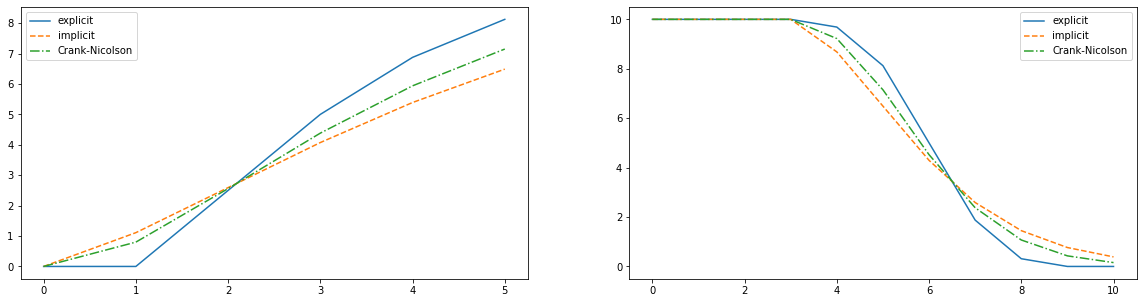

In [557]:
print(u_exp[-1])
print(u_imp[-1])
print(u_cn[-1])
fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.array(u_exp)[:,5])
axes[0].plot(np.array(u_imp)[:,5],'--')
axes[0].plot(np.array(u_cn)[:,5],'-.')
axes[0].legend(['explicit','implicit','Crank-Nicolson'])
axes[1].plot(u_exp[-1])
axes[1].plot(u_imp[-1],'--')
axes[1].plot(u_cn[-1],'-.')
axes[1].legend(['explicit','implicit','Crank-Nicolson'])